# Welcome to the HydraNet Home Robot Workshop 🐸🐸🐸

In this workshop, you're going to learn how to train a Neural Network that does **real-time semantic segmentation and monocular depth prediction**.

![](https://d3i71xaburhd42.cloudfront.net/435d4b5c30f10753d277848a17baddebd98d3c31/2-Figure1-1.png)

The Model is [a Multi-Task Learning algorithm designed by Vladimir Nekrasov](https://arxiv.org/pdf/1809.04766.pdf). The entire work is based on the **DenseTorch Library**, that you can find and use [here](https://github.com/DrSleep/DenseTorch). <p>

**A note —** This notebook is adapting the Library with express authorization from the author for educational purpose.

## Home Robot 🤖
* In the previous workshop of the course, you learned how to design the model shown above, and to run it on the KITTI Dataset using pretrained weights. The **KITTI Dataset only has 200 examples of segmentation**. Therefore, the authors used a technique called Knowledge Distillation and finetuned using the Cityscape dataset.<p>

* 👉 In our case, we'll use another dataset called the [NYUDv2 Dataset](https://cs.nyu.edu/~silberman/datasets/nyu_depth_v2.html). **It contains 1449 annotated images for depth and segmentation**, which makes our life much simpler. —— Since this is an indoor dataset, we'll turn this project into a Home Robot Workshop!

#1 — Imports

We're going to import:
*   The **Data from our previous notebook** (trained model, cmaps, ...)
*   The **NYUD Dataset**, along with helper files, ground truth examples, and train/test split files




In [2]:
!wget https://hydranets-data.s3.eu-west-3.amazonaws.com/hydranets-data-2.zip && unzip -q hydranets-data-2.zip && mv hydranets-data-2/* . && rm hydranets-data-2.zip && rm -rf hydranets-data-2

--2022-12-21 03:11:50--  https://hydranets-data.s3.eu-west-3.amazonaws.com/hydranets-data-2.zip
Resolving hydranets-data.s3.eu-west-3.amazonaws.com (hydranets-data.s3.eu-west-3.amazonaws.com)... 52.95.154.82
Connecting to hydranets-data.s3.eu-west-3.amazonaws.com (hydranets-data.s3.eu-west-3.amazonaws.com)|52.95.154.82|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 812068227 (774M) [application/zip]
Saving to: ‘hydranets-data-2.zip’

hydranets-data-2.zi 100%[===================>] 774.45M  45.1MB/s    in 17s     

2022-12-21 03:12:08 (45.0 MB/s) - ‘hydranets-data-2.zip’ saved [812068227/812068227]



In [26]:
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

# 1 — Dataset
Let's begin with importing our data, and visualizing it.

## Load and Visualize the Dataset

In [27]:
import glob

depth = sorted(glob.glob('/kaggle/working/nyud/depth/*.png'))
seg = sorted(glob.glob('/kaggle/working/nyud/masks/*.png'))
images = sorted(glob.glob('/kaggle/working/nyud/rgb/*.png'))

In [28]:
print(len(images))
print(len(depth))
print(len(seg))

1449
1449
1449


Since our dataset is a bit "special", we'll need a Color Map to read it.

In [29]:
CMAP = np.load('cmap_nyud.npy')
print(len(CMAP))

256


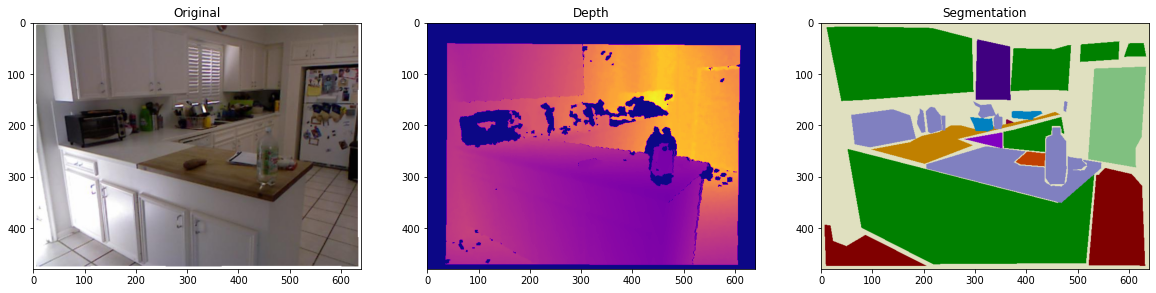

In [30]:
idx = np.random.randint(0,len(seg))

f, (ax0, ax1, ax2) = plt.subplots(1,3, figsize=(20,40))
ax0.imshow(np.array(Image.open(images[idx])))
ax0.set_title("Original")
ax1.imshow(np.array(Image.open(depth[idx])), cmap="plasma")
ax1.set_title("Depth")
ax2.imshow(CMAP[np.array(Image.open(seg[idx]))])
ax2.set_title("Segmentation")
plt.show()

In [31]:
print(np.unique(np.array(Image.open(seg[idx]))))
print(len(np.unique(np.array(Image.open(seg[idx])))))

[  1   2  11  12  23  25  33  37  38  39 255]
11


## Getting the DataLoader

When training a model, 2 elements are going to be very important (compared to the last workshop):

*   The Dataset
*   The Training Loop, Loss, etc

We already know how to design the model that does join depth and segmentation, so we only need to know how to train it!

In [32]:
data_file = "train_list_depth.txt"

with open(data_file, "rb") as f:
    datalist = f.readlines()
datalist = [x.decode("utf-8").strip("\n").split("\t") for x in datalist]

root_dir = "/nyud"
masks_names = ("segm", "depth")

print(datalist[0])

['rgb/000003.png', 'masks/000003.png', 'depth/000003.png']


In [33]:
import os
abs_paths = [os.path.join("nyud", rpath) for rpath in datalist[0]]
abs_paths

['nyud/rgb/000003.png', 'nyud/masks/000003.png', 'nyud/depth/000003.png']

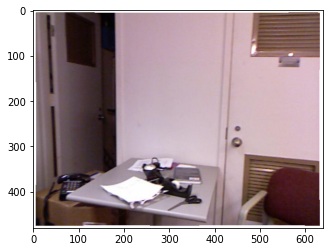

In [34]:
img_arr = np.array(Image.open(abs_paths[0]))

plt.imshow(img_arr)
plt.show()

segm
nyud/masks/000003.png


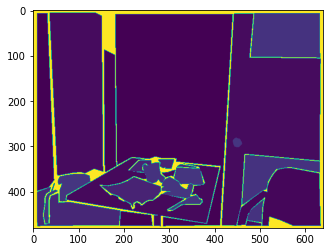

depth
nyud/depth/000003.png


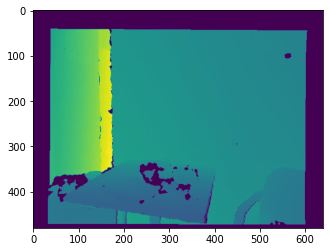

In [35]:
masks_names = ("segm", "depth")

for mask_name, mask_path in zip(masks_names, abs_paths[1:]):
    print(mask_name)
    print(mask_path)
    mask = np.array(Image.open(mask_path))
    plt.imshow(mask)
    plt.show()

In [36]:
from torch.utils.data import Dataset

class HydranetDataset(Dataset):

    def __init__(self, data_file, transform=None):
        with open(data_file, "rb") as f:
            datalist = f.readlines()
        self.datalist = [x.decode("utf-8").strip("\n").split("\t") for x in datalist]
        self.root_dir = "nyud"
        self.transform = transform
        self.masks_names = ("segm", "depth")

    def __len__(self):
        return len(self.datalist)

    def __getitem__(self, idx):
        abs_paths = [os.path.join(self.root_dir, rpath) for rpath in self.datalist[idx]] # Will output list of nyud/*/00000.png
        sample = {}
        sample["image"] = np.array(Image.open(abs_paths[0]))

        for mask_name, mask_path in zip(self.masks_names, abs_paths[1:]):
            mask = np.array(Image.open(mask_path))
            assert len(mask.shape) == 2, "Masks must be encoded without colourmap"
            sample[mask_name] = mask

        if self.transform:
            sample["names"] = self.masks_names
            sample = self.transform(sample)
            # the names key can be removed by the transformation
            if "names" in sample:
                del sample["names"]
        return sample

### Normalization — Will be common to all images


In [14]:
from utils import Normalise, RandomCrop, ToTensor, RandomMirror
import torchvision.transforms as transforms

In [15]:
img_scale = 1.0 / 255
depth_scale = 5000.0

img_mean = np.array([0.485, 0.456, 0.406])
img_std = np.array([0.229, 0.224, 0.225])

normalise_params = [img_scale, img_mean.reshape((1, 1, 3)), img_std.reshape((1, 1, 3)), depth_scale,]

transform_common = [Normalise(*normalise_params), ToTensor()]

### Transforms

In [16]:
crop_size = 400
transform_train = transforms.Compose([RandomMirror(), RandomCrop(crop_size)] + transform_common)
transform_val = transforms.Compose(transform_common)

### DataLoader

In [17]:
train_batch_size = 4
val_batch_size = 4
train_file = "train_list_depth.txt"
val_file = "val_list_depth.txt"

In [18]:
from torch.utils.data import DataLoader

#TRAIN DATALOADER
trainloader = DataLoader(
    HydranetDataset(train_file, transform=transform_train,),
    batch_size=train_batch_size,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    drop_last=True)

# VALIDATION DATALOADER
valloader = DataLoader(HydranetDataset(val_file, transform=transform_val,),
    batch_size=val_batch_size, 
    shuffle=False, num_workers=4, 
    pin_memory=True,
    drop_last=False)

# 2 — Creating the HydraNet
We now have 2 DataLoaders: one for training, and one for validation/test. <p>

In the next step, we're going to define our model, following the paper [Real-Time Joint Semantic Segmentation and Depth Estimation Using Asymmetric Annotations](https://arxiv.org/pdf/1809.04766.pdf) —— If you haven't read it yet, now is the time.
<p>

> ![](https://d3i71xaburhd42.cloudfront.net/435d4b5c30f10753d277848a17baddebd98d3c31/2-Figure1-1.png)

Our model takes an input RGB image, make it go through an encoder, a lightweight refinenet decoder, and then has 2 heads, one for each task.<p>
Things to note:
* The only **convolutions** we'll need will be 3x3 and 1x1
* We also need a **MaxPooling 5x5**
* **CRP-Blocks** are implemented as Skip-Connection Operations
* **Each Head is made of a 1x1 convolution followed by a 3x3 convolution**, only the data and the loss change there


## Building the Encoder — A MobileNetv2
![](https://iq.opengenus.org/content/images/2020/11/conv_mobilenet_v2.jpg)

In [19]:
def conv3x3(in_channels, out_channels, stride=1, dilation=1, groups=1, bias=False):
    """3x3 Convolution: Depthwise: 
    https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
    """
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=dilation, dilation=dilation, bias=bias, groups=groups)

In [20]:
def conv1x1(in_channels, out_channels, stride=1, groups=1, bias=False,):
    "1x1 Convolution: Pointwise"
    return nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, padding=0, bias=bias, groups=groups)

In [21]:
def batchnorm(num_features):
    """
    https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html
    """
    return nn.BatchNorm2d(num_features, affine=True, eps=1e-5, momentum=0.1)

In [22]:
def convbnrelu(in_channels, out_channels, kernel_size, stride=1, groups=1, act=True):
    "conv-batchnorm-relu"
    if act:
        return nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=int(kernel_size / 2.), groups=groups, bias=False),
                             batchnorm(out_channels),
                             nn.ReLU6(inplace=True))
    else:
        return nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=int(kernel_size / 2.), groups=groups, bias=False),
                             batchnorm(out_channels))

In [23]:
class InvertedResidualBlock(nn.Module):
    """Inverted Residual Block from https://arxiv.org/abs/1801.04381"""
    def __init__(self, in_planes, out_planes, expansion_factor, stride=1):
        super().__init__() # Python 3
        intermed_planes = in_planes * expansion_factor
        self.residual = (in_planes == out_planes) and (stride == 1) # Boolean/Condition
        self.output = nn.Sequential(convbnrelu(in_planes, intermed_planes, 1),
                                    convbnrelu(intermed_planes, intermed_planes, 3, stride=stride, groups=intermed_planes),
                                    convbnrelu(intermed_planes, out_planes, 1, act=False))

    def forward(self, x):
        #residual = x
        out = self.output(x)
        if self.residual:
            return (out + x)#+residual
        else:
            return out

In [24]:
class MobileNetv2(nn.Module):
    def __init__(self, return_idx=[6]):
        super().__init__()
        # expansion rate, output channels, number of repeats, stride
        self.mobilenet_config = [
        [1, 16, 1, 1],
        [6, 24, 2, 2],
        [6, 32, 3, 2],
        [6, 64, 4, 2],
        [6, 96, 3, 1],
        [6, 160, 3, 2],
        [6, 320, 1, 1],
        ]
        self.in_channels = 32  # number of input channels
        self.num_layers = len(self.mobilenet_config)
        self.layer1 = convbnrelu(3, self.in_channels, kernel_size=3, stride=2)
    
        self.return_idx = [1, 2, 3, 4, 5, 6]
        #self.return_idx = make_list(return_idx)

        c_layer = 2
        for t, c, n, s in self.mobilenet_config:
            layers = []
            for idx in range(n):
                layers.append(InvertedResidualBlock(self.in_channels,c,expansion_factor=t,stride=s if idx == 0 else 1,))
                self.in_channels = c
            setattr(self, "layer{}".format(c_layer), nn.Sequential(*layers))
            c_layer += 1

        self._out_c = [self.mobilenet_config[idx][1] for idx in self.return_idx] # Output: [24, 32, 64, 96, 160, 320]

    def forward(self, x):
        outs = []
        x = self.layer1(x)
        outs.append(self.layer2(x))  # 16, x / 2
        outs.append(self.layer3(outs[-1]))  # 24, x / 4
        outs.append(self.layer4(outs[-1]))  # 32, x / 8
        outs.append(self.layer5(outs[-1]))  # 64, x / 16
        outs.append(self.layer6(outs[-1]))  # 96, x / 16
        outs.append(self.layer7(outs[-1]))  # 160, x / 32
        outs.append(self.layer8(outs[-1]))  # 320, x / 32
        return [outs[idx] for idx in self.return_idx]

In [25]:
encoder = MobileNetv2()
encoder.load_state_dict(torch.load("mobilenetv2-e6e8dd43.pth"))

<All keys matched successfully>

In [ ]:
dummy_input = Variable(torch.randn(1,3,128,128))
torch.onnx.export(trained_model, dummy_input, “your_model.onnx”)

In [56]:
# print(encoder)

## Building the Decoder - A Multi-Task Lighweight RefineNet
Paper: https://arxiv.org/pdf/1810.03272.pdf
![](https://drsleep.github.io/images/rf_arch.png)

In [57]:
def make_list(x):
    """Returns the given input as a list."""
    if isinstance(x, list):
        return x
    elif isinstance(x, tuple):
        return list(x)
    else:
        return [x]

In [58]:
class CRPBlock(nn.Module):
    """CRP definition"""
    def __init__(self, in_planes, out_planes, n_stages, groups=False):
        super().__init__()
        for i in range(n_stages):
            setattr(self, '{}_{}'.format(i + 1, 'outvar_dimred'),
                    conv1x1(in_planes if (i == 0) else out_planes,
                            out_planes, stride=1,
                            bias=False, groups=in_planes if groups else 1))
        self.stride = 1
        self.n_stages = n_stages
        self.maxpool = nn.MaxPool2d(kernel_size=5, stride=1, padding=2)

    def forward(self, x):
        top = x
        for i in range(self.n_stages):
            top = self.maxpool(top)
            top = getattr(self, '{}_{}'.format(i + 1, 'outvar_dimred'))(top)
            x = top + x
        return x

In [37]:
class MTLWRefineNet(nn.Module):
    def __init__(self, input_sizes, num_classes, agg_size=256, n_crp=4):
        super().__init__()

        stem_convs = nn.ModuleList()
        crp_blocks = nn.ModuleList()
        adapt_convs = nn.ModuleList()
        heads = nn.ModuleList()

        # Reverse since we recover information from the end
        input_sizes = list(reversed((input_sizes)))

        # No reverse for collapse indices is needed
        self.collapse_ind = [[0, 1], [2, 3], 4, 5]

        groups = [False] * len(self.collapse_ind)
        groups[-1] = True

        for size in input_sizes:
            stem_convs.append(conv1x1(size, agg_size, bias=False))

        for group in groups:
            crp_blocks.append(self._make_crp(agg_size, agg_size, n_crp, group))
            adapt_convs.append(conv1x1(agg_size, agg_size, bias=False))

        self.stem_convs = stem_convs
        self.crp_blocks = crp_blocks
        self.adapt_convs = adapt_convs[:-1]

        num_classes = list(num_classes)
        for n_out in num_classes:
            heads.append(
                nn.Sequential(
                    conv1x1(agg_size, agg_size, groups=agg_size, bias=False),
                    nn.ReLU6(inplace=False),
                    conv3x3(agg_size, n_out, bias=True),
                )
            )

        self.heads = heads
        self.relu = nn.ReLU6(inplace=True)

    def forward(self, xs):
        xs = list(reversed(xs))
        for idx, (conv, x) in enumerate(zip(self.stem_convs, xs)):
            xs[idx] = conv(x)

        # Collapse layers
        c_xs = [sum([xs[idx] for idx in make_list(c_idx)]) for c_idx in self.collapse_ind ]

        for idx, (crp, x) in enumerate(zip(self.crp_blocks, c_xs)):
            if idx == 0:
                y = self.relu(x)
            else:
                y = self.relu(x + y)
            y = crp(y)
            if idx < (len(c_xs) - 1):
                y = self.adapt_convs[idx](y)
                y = F.interpolate(
                    y,
                    size=c_xs[idx + 1].size()[2:],
                    mode="bilinear",
                    align_corners=True,
                )

        outs = []
        for head in self.heads:
            outs.append(head(y))
        return outs

    @staticmethod
    def _make_crp(in_planes, out_planes, stages, groups):
        # Same as previous, but showing the use of a @staticmethod
        layers = [CRPBlock(in_planes, out_planes, stages, groups)]
        return nn.Sequential(*layers)

In [41]:
num_classes = (40, 1)
decoder = MTLWRefineNet(encoder._out_c, num_classes)
# print(decoder)

# 3 — Train the Model

Now that we've define our encoder and decoder. We are ready to train our model on the NYUDv2 Dataset.

Here's what we'll need:

*   Functions like **train() and valid()**
*   **An Optimizer and a Loss Function**
*   **Hyperparameters** such as Weight Decay, Momentum, Learning Rate, Epochs, ...

Doesn't sound so bad, does it?

## Loss Function

Let's begin with the Loss and Optimization we'll need.

* The **Segmentation Loss** is the **Cross Entropy Loss**, working as a per-pixel classification function with 15 or so classes.

* The **Depth Loss** will be the **Inverse Huber Loss**.

In [ ]:
from utils import InvHuberLoss

ignore_index = 255
ignore_depth = 0

crit_segm = #TODO: Define the Loss for Segmentation
crit_depth = #TODO: Define the Loss for Depth

## Optimizer
For the optimizer, we'll use the **Stochastic Gradient Descent**. We'll also add techniques such as weight decay or momentum.

In [ ]:
lr_encoder = 1e-2
lr_decoder = 1e-3
momentum_encoder = 0.9
momentum_decoder = 0.9
weight_decay_encoder = 1e-5
weight_decay_decoder = 1e-5

In [ ]:
optims = #TODO: Create a List of 2 Optimizers: One for the encoder, one for the decoder

## Model Definition & State Loading

In [ ]:
n_epochs = 1000

In [ ]:
from model_helpers import Saver, load_state_dict
import operator 
import json
import logging

init_vals = (0.0, 10000.0)
comp_fns = [operator.gt, operator.lt]
ckpt_dir = "./"
ckpt_path = "./checkpoint.pth.tar"

saver = Saver(
    args=locals(),
    ckpt_dir=ckpt_dir,
    best_val=init_vals,
    condition=comp_fns,
    save_several_mode=all,
)

In [ ]:
hydranet = nn.DataParallel(nn.Sequential(encoder, decoder).cuda()) # Use .cpu() if you prefer a slow death

print("Model has {} parameters".format(sum([p.numel() for p in hydranet.parameters()])))

start_epoch, _, state_dict = saver.maybe_load(ckpt_path=ckpt_path, keys_to_load=["epoch", "best_val", "state_dict"],)
load_state_dict(hydranet, state_dict)

if start_epoch is None:
    start_epoch = 0

In [ ]:
print(start_epoch)

## Learning Rate Scheduler

In [ ]:
opt_scheds = []
for opt in optims:
    opt_scheds.append(torch.optim.lr_scheduler.MultiStepLR(opt, np.arange(start_epoch + 1, n_epochs, 100), gamma=0.1))

## Training and Validation Loops

Now, all we need to do is go through the Train and Validation DataLoaders, and train our model.

It should look like this:
```python
for i in range(start_epoch, n_epochs):
    for sched in opt_scheds:
        sched.step(i)
    hydranet.train() # Set to train mode    
    train(...) # Call the train function

    if i % val_every == 0:
        model1.eval() # Set to Eval Mode
        with torch.no_grad():
            vals = validate(...) # Call the validate function
```

In the (...), we'll send our dataloader, loss functions, optimizers, and everything we've defined before.<p>

Which means **we need a training and validate functions.**

In [ ]:
from utils import AverageMeter
from tqdm import tqdm

In [ ]:
def train(model, opts, crits, dataloader, loss_coeffs=(1.0,), grad_norm=0.0):
    model.train()

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    loss_meter = AverageMeter()
    pbar = tqdm(dataloader)

    for sample in pbar:
        loss = 0.0
        input = #TODO: Get the Input
        targets = #TODO: Get the Targets
        
        #FORWARD
        outputs = #TODO: Run a Forward pass

        for out, target, crit, loss_coeff in zip(outputs, targets, crits, loss_coeffs):
            #TODO: Increment the Loss

        # BACKWARD
        #TODO: Zero Out the Gradients
        #TODO: Call Loss.Backward

        if grad_norm > 0.0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_norm)
        #TODO: Run one step

        loss_meter.update(loss.item())
        pbar.set_description(
            "Loss {:.3f} | Avg. Loss {:.3f}".format(loss.item(), loss_meter.avg)
        )

In [ ]:
def validate(model, metrics, dataloader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    for metric in metrics:
        metric.reset()

    pbar = tqdm(dataloader)

    def get_val(metrics):
        results = [(m.name, m.val()) for m in metrics]
        names, vals = list(zip(*results))
        out = ["{} : {:4f}".format(name, val) for name, val in results]
        return vals, " | ".join(out)

    with torch.no_grad():
        for sample in pbar:
            # Get the Data
            input = sample["image"].float().to(device)
            targets = [sample[k].to(device) for k in dataloader.dataset.masks_names]

            #input, targets = get_input_and_targets(sample=sample, dataloader=dataloader, device=device)
            targets = [target.squeeze(dim=1).cpu().numpy() for target in targets]

            # Forward
            outputs = model(input)
            #outputs = make_list(outputs)

            # Backward
            for out, target, metric in zip(outputs, targets, metrics):
                metric.update(
                    F.interpolate(out, size=target.shape[1:], mode="bilinear", align_corners=False)
                    .squeeze(dim=1)
                    .cpu()
                    .numpy(),
                    target,
                )
            pbar.set_description(get_val(metrics)[1])
    vals, _ = get_val(metrics)
    print("----" * 5)
    return vals

## Main Loop

In [ ]:
from utils import MeanIoU, RMSE

In [ ]:
crop_size = 400
batch_size = 4
val_batch_size = 4
val_every = 5
loss_coeffs = (0.5, 0.5)

#TODO: Define a Training Loop! (Good Luck!)

# Inference Challenge

Now that your model is trained and checkpoint saved, try and **load an image from the test dataset and run your model on it**. Print the FPS.
<p>

**MEGA POINTS** — Load a video, and **implement a video pipeline** as we did on the previous workshop!

In [ ]:
#Good Luck! If you have any good result, send it to jeremy@thinkautonomous.ai directly!